In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# Remove the old path if it exists
#old_path = '/Users/maxw/projects/bayes_gsl'
#if old_path in sys.path:
#    sys.path.remove(old_path)

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)
""" 
# Append the new src directory to the system path
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

# Confirm that the src directory is in the system path
print("Current sys.path:")
for path in sys.path:
    print(path)

"""
# Now try importing your module using the absolute path as a check
from src.models import dpg_bnn


In [2]:
"""
    Compare all models on NLL, BS, Error, ECE.
    Plot the calibration curves and the distribution of probabilities within each bin.

"""
import os
import pickle
import arviz
import matplotlib.pyplot as plt
import numpyro.infer
import seaborn as sns
from sklearn.calibration import calibration_curve
import numpy as np

import jax.numpy as jnp
import jax


from src import TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH, FIGURES_PATH

from src.models import dpg_bnn, dpg_mimo_bnn, dpg_mimo_stochastic_head, pds_bnn
#from src.data import load_data
from src.metrics import compute_metrics

from src.config import num_samples_to_generate, w_init_scale, lam_init_scale, altered_prior
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
from src import NUM_BINS

In [3]:
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
models = {
        'DPG': (dpg_bnn, dpg_hyperparameters, f"dpg_D={dpg_hyperparameters['depth']}.pkl"),
        'PDS': (pds_bnn, pds_hyperparameters, f"pds_D={dpg_hyperparameters['depth']}.pkl"),
        'DPG-MIMO': (dpg_mimo_bnn, dpg_mimo_hyperparameters, f"dpg_mimo_D={dpg_mimo_hyperparameters['depth']}_C={dpg_mimo_hyperparameters['num_channels']}.pkl"),
        'DPG-MIMO-E': (dpg_mimo_stochastic_head, dpg_mimo_e_hyperparameters, f"dpg_mimo_e_D={dpg_mimo_e_hyperparameters['mimo_base']['depth']}_C={dpg_mimo_e_hyperparameters['mimo_base']['num_channels']}_stoch_head_C={dpg_mimo_e_hyperparameters['num_stochastic_channels']}_D={dpg_mimo_e_hyperparameters['stochastic_head_depth']}.pkl")
    }

In [4]:
# load the results from dictionary
from experiments.covariate_shift.run import PATH2COVARIATE_SHIFT_RESULTS, display_metrics
covariate_shift_metrics_file = os.path.join(PATH2COVARIATE_SHIFT_RESULTS, 'covariate_shift_metrics.pkl')

# ensure the file exists, if not warn user
if not os.path.exists(covariate_shift_metrics_file):
    print(f"The file {covariate_shift_metrics_file} does not exist. Please run the covariate shift experiment first.")

with open(covariate_shift_metrics_file, 'rb') as f:
    model_metrics_dicts = pickle.load(f)

for model_name, num_signals_to_metrics_dict in model_metrics_dicts.items():
    print(model_name)
    for num_signals, metrics_dict in num_signals_to_metrics_dict.items():
        print(num_signals)
        display_metrics(metrics_dict)
        print()

Number of CPU cores: 1
DPG
expected
Test Error: 0.01573682 \pm 0.01008262
Test NLL: 10.333 \pm 5.378
Test BS: 0.01286086 \pm 0.00716473
Test ECE:0.00341998

10
Test Error: 0.13584214 \pm 0.05149131
Test NLL: 132.161 \pm 49.024
Test BS: 0.12377965 \pm 0.04657596
Test ECE:0.11222789

20
Test Error: 0.09515780 \pm 0.04152015
Test NLL: 78.087 \pm 34.818
Test BS: 0.08350260 \pm 0.03659543
Test ECE:0.07142366

100
Test Error: 0.03599995 \pm 0.01675503
Test NLL: 22.087 \pm 9.398
Test BS: 0.02892044 \pm 0.01254435
Test ECE:0.01646109

1000
Test Error: 0.01805252 \pm 0.01134341
Test NLL: 11.277 \pm 5.571
Test BS: 0.01429300 \pm 0.00769689
Test ECE:0.00375998

10000
Test Error: 0.01599991 \pm 0.01052421
Test NLL: 10.458 \pm 5.478
Test BS: 0.01303431 \pm 0.00735640
Test ECE:0.00329874

PDS
expected
Test Error: 0.01589471 \pm 0.01025924
Test NLL: 10.317 \pm 5.391
Test BS: 0.01285023 \pm 0.00717723
Test ECE:0.00374968

10
Test Error: 0.13578951 \pm 0.05164335
Test NLL: 132.389 \pm 49.210
Test BS: 0

In [5]:
def list2str(l):
    return ["{:.3f}".format(x) for x in l]

def print_metrics(dict, name, num_signals):
    print(f"{name} metrics:")
    print('\tNLL: ', list2str([-1 * dict[num_signal]['log_likelihoods'].mean()._value for num_signal in num_signals]))
    print('\tBS: ', list2str([dict[num_signal]['brier_scores'].mean()._value for num_signal in num_signals]))
    print('\tError: ', list2str([1 - dict[num_signal]['accuracies'].mean()._value for num_signal in num_signals]))
    print('\tECE: ', list2str([dict[num_signal]['calibration_dict']['ece'] for num_signal in num_signals]))


In [6]:
num_signals = list(model_metrics_dicts['DPG'].keys())
# 'expected' should be first, then the tail should be in decreasing order
num_signals = ['expected'] + [str(x) for x in sorted([int(x) for x in num_signals if x != 'expected'], reverse=True)]
# replace 'expected' with inf
#num_signals = [np.inf if x == 'expected' else float(x) for x in num_signals]
# ensure sorted in decreasing order
#num_signals = sorted(num_signals, reverse=True)
print(num_signals)

for model_name, num_signals_to_metrics_dict in model_metrics_dicts.items():
    print_metrics(num_signals_to_metrics_dict, model_name, num_signals)

['expected', '10000', '1000', '100', '20', '10']
DPG metrics:
	NLL:  ['10.333', '10.458', '11.277', '22.087', '78.087', '132.161']
	BS:  ['0.013', '0.013', '0.014', '0.029', '0.084', '0.124']
	Error:  ['0.016', '0.016', '0.018', '0.036', '0.095', '0.136']
	ECE:  ['0.003', '0.003', '0.004', '0.016', '0.071', '0.112']
PDS metrics:
	NLL:  ['10.317', '10.440', '11.256', '22.025', '78.072', '132.389']
	BS:  ['0.013', '0.013', '0.014', '0.029', '0.083', '0.124']
	Error:  ['0.016', '0.016', '0.018', '0.036', '0.095', '0.136']
	ECE:  ['0.004', '0.003', '0.004', '0.016', '0.072', '0.112']
DPG-MIMO metrics:
	NLL:  ['9.191', '9.360', '10.334', '24.180', '110.271', '191.648']
	BS:  ['0.012', '0.012', '0.013', '0.029', '0.084', '0.123']
	Error:  ['0.014', '0.015', '0.017', '0.037', '0.097', '0.137']
	ECE:  ['0.004', '0.003', '0.004', '0.017', '0.074', '0.112']
DPG-MIMO-E metrics:
	NLL:  ['8.354', '8.543', '9.575', '24.126', '109.861', '191.754']
	BS:  ['0.011', '0.011', '0.012', '0.029', '0.085', '

In [13]:
model_metrics_dicts['DPG']['expected']['log_likelihoods'].mean()._value

array(-10.332913, dtype=float32)

In [19]:
num_signals

['10', '20', '100', '1000', '10000']

In [17]:
# remove 'expected' from num_signals and then sort in increasing order (cast to int)
num_signals = [str(x) for x in num_signals if x != 'expected']
num_signals = sorted(num_signals, key=lambda x: int(x))

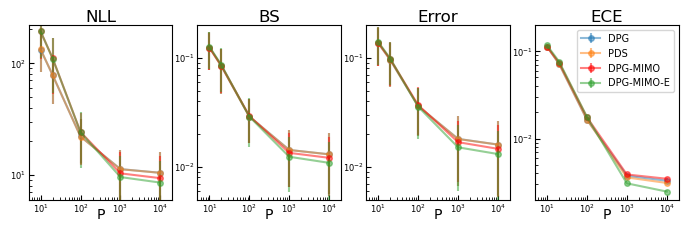

In [22]:
colors = {'DPG': '#1f77b4', 'PDS': '#ff7f0e', 
          'DPG-MIMO': 'red',
          'DPG-MIMO-E': '#2ca02c'}

num_plots = 4
tick_fontsize = 6
label_fontsize = 10
alpha, markersize = 0.5, 4
fig, axes = plt.subplots(1, num_plots, figsize=(TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH))
nll_ax, bs_ax, err_ax, ece_ax = axes
stdv_scale = 1

for ax, title in zip(axes, ['NLL', 'BS', 'Error', 'ECE']):
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.title.set_text(title)
    ax.set_title(title, y=.97)
    ax.tick_params(axis='both', which='both', direction='in', pad=2, labelsize=tick_fontsize)
    ax.set_xlabel('P', fontsize=label_fontsize, labelpad=-5)
    ax.set_xlim([5, 20000])
    ax.set_xticks([10, 100, 1000, 10000])
    ax.set_xticklabels([r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=tick_fontsize)
    # set size of y tick labels



""" NLL """
for name in model_metrics_dicts.keys():
    nll_ax.errorbar(
        [int(x) for x in num_signals],
        [-1 * model_metrics_dicts[name][num_signal]['log_likelihoods'].mean()._value for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['log_likelihoods'].std()._value for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
nll_ax.set_ylim([6, 220])
#nll_ax.set_yticks([10, 15, 20, 25])
# clear all yticklabels and set manually
#nll_ax.set_yticklabels([10, 15, 20, 25], fontsize=tick_fontsize)

# Brier Score
for name in model_metrics_dicts.keys():
    bs_ax.errorbar(
        [int(x) for x in num_signals],
        [model_metrics_dicts[name][num_signal]['brier_scores'].mean()._value for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['brier_scores'].std()._value for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
bs_ax.set_ylim([0.005, 0.2])
#bs_ax.set_yticks([0.1, 0.2, 0.3, 0.4])
#bs_ax.set_yticklabels(['.1', '.2', '.3', '.4'], fontsize=tick_fontsize)
#bs_ax.legend(loc='upper right', fontsize=label_fontsize-3)

# Error
for name in model_metrics_dicts.keys():
    err_ax.errorbar(
        [int(x) for x in num_signals],
        [1 - model_metrics_dicts[name][num_signal]['accuracies'].mean() for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['accuracies'].std() for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
err_ax.set_ylim([0.005, 0.2])
#err_ax.set_yticks([0.01, 0.1, 0.2])
#err_ax.set_yticklabels(['.01', '.1', '.2'], fontsize=tick_fontsize)

# ECE
for name in model_metrics_dicts.keys(): #['dpg', 'pds', 'mimo', 'partial_stoch']:
    ece_ax.errorbar(
        [int(x) for x in num_signals],
        [model_metrics_dicts[name][num_signal]['calibration_dict']['ece'].mean() for num_signal in num_signals],
        yerr=[stdv_scale * model_metrics_dicts[name][num_signal]['calibration_dict']['ece'].std() for num_signal in num_signals],
        label=name,
        color = colors[name],
        alpha=alpha,
        markersize=markersize,
        marker='o') #markersize=2, linewidth=0.5)
ece_ax.set_ylim([.002, .2])
#ece_ax.set_yticks([.01, .1])
#ece_ax.set_yticklabels(['.01', '.1'], fontsize=tick_fontsize)
ece_ax.legend(loc='upper right', fontsize=label_fontsize-3)


space = .175
plt.subplots_adjust(wspace=space, hspace=space, bottom=0.0, top=1, left=0.0, right=1.0)
plt.savefig(FIGURES_PATH + 'covariate_shift', dpi=1000, bbox_inches="tight", pad_inches=0.02)